## Machine Vision for Automated Robot Handling

#### Importing Dependencies

In [42]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.ndimage import shift
import math
import random

####  Preprocessing the metal and roboter image

Creating a mask for the robot's arm 

In [43]:
def gripper_mask(gripper_url): 
    # Read the PNG image as Grayscale 
    gripper_image = cv.imread(gripper_url, cv.IMREAD_GRAYSCALE) 

    # Segment mask through Threshodling 
    _, gripper_mask = cv.threshold(gripper_image, 0, 255, cv.THRESH_BINARY)
    
    return gripper_mask

Visualisation 

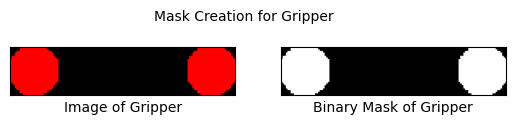

In [44]:
fig, axs = plt.subplots(1,2)
robotarm = cv.imread("Demo_Images/robotarm_1.png")
robotarm_mask = gripper_mask("Demo_Images/robotarm_1.png")
fig.text(0.35,0.6, "Mask Creation for Gripper", weight="roman")
axs[0].imshow(robotarm)
axs[0].set_xlabel("Image of Gripper")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(robotarm_mask, cmap="gray")
axs[1].set_xlabel("Binary Mask of Gripper")
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

Creating a mask for the metal sheet 

In [45]:
def metal_sheet_mask(metal_url):
    # Read the PNG image with alpha channel 
    image = cv.imread(metal_url, cv.IMREAD_UNCHANGED)

    # Validate, that image has an alpha channel 
    if image.shape[2] == 4:
        alpha_channel = image[:, :, 3]
    else: 
        return metal_sheet_mask_without_alpha(metal_url)

    # Create a binary mask 
    _, binary_mask = cv.threshold(alpha_channel, 1, 255, cv.THRESH_BINARY)

    # Create mask through contours
    _, binary_mask = cv.threshold(alpha_channel, 1, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(binary_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    outer_mask = np.zeros_like(binary_mask)

    cv.drawContours(outer_mask, contours, -1, 255, thickness=cv.FILLED)

    return outer_mask

Creating a mask for the holes

In [46]:
def detect_punchings(image_path):
    # Read the PNG image
    image = cv.imread(image_path, cv.IMREAD_UNCHANGED)

    # Convert image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to smooth noise
    blurred = cv.GaussianBlur(gray, (7, 7), 0)

    # Detect edges with canny algorithm
    edges = cv.Canny(blurred, threshold1=30, threshold2=100)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    closed_edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

    contours, _ = cv.findContours(closed_edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)

    for contour in contours:
        area = cv.contourArea(contour)
        perimeter = cv.arcLength(contour, True)
        circularity = 4 * np.pi * (area / (perimeter * perimeter)) if perimeter > 0 else 0

        if area > 20:  
            cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)

    # Removing small noise
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=8)
    for label in range(1, num_labels):  
        area = stats[label, cv.CC_STAT_AREA]
        if area < 30:  
            mask[labels == label] = 0

    return cv.bitwise_not(mask)

Combine metal masks

In [47]:
def combine_masks_of_metal(mask_metal, mask_holes):
    return np.minimum(mask_metal, mask_holes)

Combined Preprocessing 

In [48]:
def preprocessing_pipeline(metal_url, gripper_url):
    metal_mask = metal_sheet_mask(metal_url)
    mask_holes = detect_punchings(metal_url)
    mask_gripper = gripper_mask(gripper_url) 

    combine_mask = combine_masks_of_metal(metal_mask, mask_holes)
    
    # Add third dimension for compatibilty with simulated annealing
    metal_mask_3_channel = cv.bitwise_not(cv.merge([metal_mask] * 3))
    mask_gripper_3_channel = cv.merge([mask_gripper] * 3)
    combine_mask_3_channel = cv.bitwise_not(cv.merge([combine_mask] * 3))

    
    return combine_mask_3_channel, mask_gripper_3_channel

Demo for mask creation 

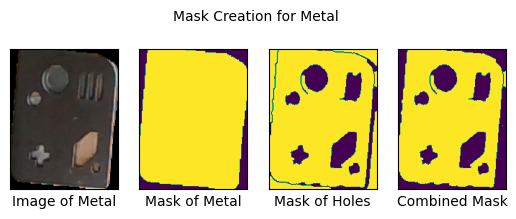

In [66]:
# URLs for demo images
metalpart_one_url = "Demo_Images/metal_1.png"
metalpart_two_url = "Demo_Images/metal_2.png"
robotarm_one_url = "Demo_Images/robotarm_1.png"
robotarm_two_url = "Demo_Images/robotarm_2.png"

# Create masks 
original_metal_one = cv.imread(metalpart_one_url)
outermask_metal_one = metal_sheet_mask(metalpart_one_url)
segmentationmask_metal_one = detect_punchings(metalpart_one_url)
completemask_metal_one = combine_masks_of_metal(outermask_metal_one, segmentationmask_metal_one) 

# Visualize 
titles = ["Image of Metal", "Mask of Metal", "Mask of Holes", "Combined Mask"]
images = [original_metal_one, outermask_metal_one, segmentationmask_metal_one, completemask_metal_one]
fig, axs = plt.subplots(1,4)
fig.text(0.38,0.7, "Mask Creation for Metal", weight="roman")
for plot in range(4):
    axs[plot].imshow(images[plot])
    axs[plot].set_xlabel(titles[plot])
    axs[plot].set_xticks([])
    axs[plot].set_yticks([])

#### Determining gripper position 

Defining some helper functions 

Make the gripper and metal mask the same shape

In [ ]:
def pad_to_match_size(gripper, target_size):
    
    # Rotate gripper if it is too large
    if(gripper.shape[0] > target_size.shape[0] or gripper.shape[1] > target_size.shape[1]):
        gripper = cv.rotate(gripper, cv.ROTATE_90_CLOCKWISE)

    # Calculate padding 
    rows_gripper, cols_gripper = gripper.shape[:2]
    target_rows, target_cols = target_size.shape[:2]
    pad_top = (target_rows - rows_gripper) // 2
    pad_bottom = target_rows - rows_gripper - pad_top
    pad_left = (target_cols - cols_gripper) // 2
    pad_right = target_cols - cols_gripper - pad_left

    # Add padding
    if(gripper.ndim == 3):
        return np.pad(gripper, ((pad_top, pad_bottom), (pad_left, pad_right),(0,0)), mode='constant', constant_values=0)
    else:
        return np.pad(gripper, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)


Check if gripper placement is illegal

In [52]:
def is_out_of_bounds(metal, x, y, a, original_gripper):

    # Convert angle to radians
    angle_rad = math.radians(a)

    # Gripper dimensions
    gripper_height = original_gripper.shape[0]
    gripper_width = original_gripper.shape[1]

    # Calculate the four corners of the gripper relative to its center
    corners = np.array([
        [-gripper_height / 2, -gripper_width / 2],
        [-gripper_height / 2,  gripper_width / 2],
        [ gripper_height / 2, -gripper_width / 2],
        [ gripper_height / 2,  gripper_width / 2],
    ])

    # Rotation matrix
    rotation_matrix = np.array([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad),  math.cos(angle_rad)],
    ])

    # Rotate corners
    rotated_corners = np.dot(corners, rotation_matrix.T)

    # Translate corners to (x, y)
    transformed_corners = rotated_corners + np.array([y, x])

    # Check if any corner is out of bounds
    out_of_bounds = np.any(
        (transformed_corners[:, 0] < 0) | (transformed_corners[:, 0] >= metal.shape[0]) |
        (transformed_corners[:, 1] < 0) | (transformed_corners[:, 1] >= metal.shape[1])
    )

    return out_of_bounds


Function for transforming the gripper

In [67]:
def transform_gripper(gripper, dx,dy,da):
    rotated_mask= rotate(gripper, angle=da, reshape=False, mode='nearest', order=1)
    
    if(gripper.ndim == 3):
        translated_mask = shift(rotated_mask, shift=(dx, dy,0), mode='constant', cval=0)
    else:
        translated_mask = shift(rotated_mask, shift=(dx, dy), mode='constant', cval=0)
    
    return translated_mask

Function for calculating the center of the mask 

In [54]:
def get_center(image):
    width, height = image.shape[:2]
    return width//2, height//2

Cost Function 

In [55]:
def cost(gripper, metal, original_gripper, x , y, a): 

    # Punishing illegal positions heavily
    if(is_out_of_bounds(metal, x, y, a, original_gripper)): 
        return math.inf 

    # Calculate overlap and distance
    
    gripper_binary = (gripper > 0).astype(int)
    metal_binary = (metal > 0).astype(int) 

    dist = np.linalg.norm(get_center(metal_binary)-np.array([x,y]))
    overlap = np.logical_and(gripper_binary, metal_binary).sum()

    # Lagrange Factor (customizable) 
    lagrange = 1e6
    
    return dist + lagrange*overlap

Simulated Annealing 

In [56]:
def simulated_annealing(metal_mask, gripper_mask, initial_temp = 1000, cooling_rate=0.9, max_iter = 900):
    # Adapt gripper shape to metal shape 
    initial_rotation = 0
    if(gripper_mask.shape[0] > metal_mask.shape[0] or gripper_mask.shape[1] > metal_mask.shape[1]):
        gripper_mask = cv.rotate(gripper, cv.ROTATE_90_CLOCKWISE)
        initial_rotation += 90 

    # Saving original values 
    true_size_gripper = gripper_mask
    global_initial_x, global_initial_y = get_center(metal_mask) 
    
    initial_gripper = pad_to_match_size(true_size_gripper, metal_mask)

    # Defining initial state 
    initial_x, initial_y = global_initial_x, global_initial_y 
    current_position = (initial_x, initial_y)
    current_angle = max(0,initial_rotation) 
    current_energy = cost(initial_gripper, metal_mask, true_size_gripper, initial_x, initial_y, current_angle)

    # Initialising best position with starting position
    best_position, best_angle, best_energy = current_position, current_angle, current_energy

    temp = initial_temp 
    total_dx = 0
    total_dy = 0
    total_da = 0 

    # Main functionality
    for i in range(max_iter): 
        # Calculate random adjustment 
        dx, dy = random.randint(-10, 10), random.randint(-10, 10)
        da = random.randint(-15, 15)

        # Validate adjustment 
        while((get_center(metal_mask)[0] +total_dx+dx < 0) or (get_center(metal_mask)[0] +total_dx +dx > metal_mask.shape[0]) or get_center(metal_mask)[1]+total_dy+dy < 0 or get_center(metal_mask)[1]+total_dy+dy > metal_mask.shape[1]):
            dx, dy = random.randint(-10, 10), random.randint(-10, 10)
            da = random.randint(-15, 15)

        # Calculating new state
        total_dx += dx
        total_dy += dy
        total_da += da 
        total_da = total_da%360

        new_position = (global_initial_x + total_dx, global_initial_y + total_dy)
        new_angle = total_da

        # Transform gripper
        transformed_gripper = transform_gripper(initial_gripper, total_dx, total_dy,total_da)

        # Caclulate cost for new state
        new_energy = cost(transformed_gripper, metal_mask, true_size_gripper, new_position[0], new_position[1],new_angle)

        # Accept with probability
        delta_energy = new_energy - current_energy
        acceptance_prob = math.exp(-delta_energy / temp) if delta_energy > 0 else 1

        if random.random() < acceptance_prob - 0.1: 
            initial_x, initial_y, current_angle, current_energy = new_position[0], new_position[1], new_angle, new_energy
            current_position = (new_position[0], new_position[1])

            
            if current_energy < best_energy:
                best_position, best_angle, best_energy = current_position, current_angle, current_energy

        # Cool down
        temp = max(initial_temp * (cooling_rate ** i), 1e-2)

        # Stop early if energy is very low
        if best_energy < 1e-3:
            break

        return best_position, best_angle, best_energy


Demo for simulated annealing 

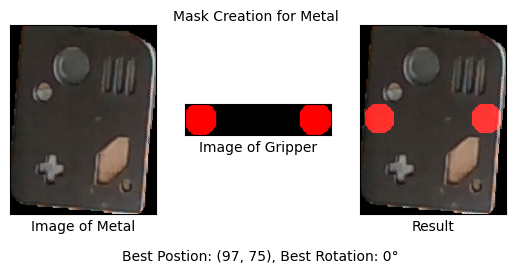

In [85]:
# Preprocessing step
mask_of_metal, mask_of_gripper = preprocessing_pipeline("Demo_Images/metal_1.png", "Demo_Images/robotarm_1.png")
gripper_padded = pad_to_match_size(cv.imread("Demo_Images/robotarm_1.png"), cv.imread("Demo_Images/metal_1.png"))

# Determine solution 
position_sol, angle_sol, _ = simulated_annealing(mask_of_metal, mask_of_gripper)
rotated_mask = transform_gripper(gripper_padded, get_center(mask_of_metal)[0]-position_sol[0], get_center(mask_of_metal)[1]-position_sol[1],angle_sol)
result = cv.bitwise_or(rotated_mask, cv.imread("Demo_Images/metal_1.png"))

# Visualize 
titles = ["Image of Metal", "Image of Gripper", "Result"]
images = [cv.imread("Demo_Images/metal_1.png"), cv.imread("Demo_Images/robotarm_1.png"), result]
fig, axs = plt.subplots(1,3)
fig.text(0.38,0.7, "Mask Creation for Metal", weight="roman")
for plot in range(3):
    axs[plot].imshow(images[plot])
    axs[plot].set_xlabel(titles[plot])
    axs[plot].set_xticks([])
    axs[plot].set_yticks([])
fig.text(0.3,0.2, f"Best Postion: {position_sol}, Best Rotation: {angle_sol}°", weight="roman")
plt.show()